## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>


</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#Intall beautifulsoup4 & lxml
!conda install -c conda-forge beautifulsoup4 --yes 
!conda install -c conda-forge lxml --yes 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/shanshanjin/opt/anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |   py37hc8dfbb8_1         3.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::

In [423]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

**1.1 Sydney house prices of 2019**

Read data

In [424]:
df_hp=pd.read_csv('SydneyHousePrices.csv')

Select PropType is house

In [425]:
df_hp['suburb']=df_hp['suburb'].str.strip()
df_hp['Year']=df_hp['Date'].str[:4]
df_hp=df_hp[(df_hp['propType']=='house')&(df_hp['sellPrice']>100000)&(df_hp['bed']>1)&(df_hp['bed']<10)]
df_hp.head()

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType,Year
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house,2019
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house,2019
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house,2019
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house,2019
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house,2019


In [426]:
df_hp.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,168746.000000,168746.000000,1.687460e+05,168746.000000,168746.000000,152823.000000
mean,99005.316979,2198.863191,1.327990e+06,3.620939,1.910214,1.997226
std,57827.816927,198.356455,5.442574e+06,0.963737,0.891795,1.084949
min,1.000000,2000.000000,1.100000e+05,2.000000,1.000000,1.000000
25%,48626.250000,2077.000000,7.550000e+05,3.000000,1.000000,1.000000
50%,98058.500000,2142.000000,1.059000e+06,4.000000,2.000000,2.000000
75%,149067.750000,2210.000000,1.550000e+06,4.000000,2.000000,2.000000
max,199504.000000,4878.000000,2.147484e+09,9.000000,14.000000,30.000000


Calculate sellprice increase rate from 2018 to 2019, avearge by suburb

In [427]:
df_hp=df_hp.groupby(['suburb','Year'])['sellPrice'].mean().reset_index().round()
df_pivot=pd.pivot_table(df_hp, values='sellPrice', index=['suburb'],columns=['Year'], aggfunc=np.mean).reset_index()
df_yoy=df_pivot.set_index('suburb').pct_change(axis='columns')[['2019']].reset_index()
df_hp=pd.merge(df_pivot[['suburb','2019']],df_yoy, on='suburb',how='left')
df_hp.rename(columns={'2019_x':'SellPrice','2019_y':'IncreaseRate'},inplace=True)
df_hp.set_index('suburb',inplace=True)
df_hp.head()

Year,SellPrice,IncreaseRate
suburb,,
Abbotsbury,890091.0,-0.233692
Abbotsford,2490000.0,-0.039475
Agnes Banks,745000.0,-0.073095
Airds,410462.0,-0.338333
Alexandria,1541867.0,-0.000998


In [428]:
df_hp.dropna(inplace=True)
df_hp.head()

Year,SellPrice,IncreaseRate
suburb,,
Abbotsbury,890091.0,-0.233692
Abbotsford,2490000.0,-0.039475
Agnes Banks,745000.0,-0.073095
Airds,410462.0,-0.338333
Alexandria,1541867.0,-0.000998


Normanize sellprice and increase rate

In [429]:
df_hp_scale=pd.DataFrame(preprocessing.scale(df_hp),columns={'SDSell','SDIR'})

In [430]:
df_hp_scale.head()

,SDSell,SDIR
0,-0.497716,-0.729076
1,1.074611,0.154194
2,-0.640306,0.001297
3,-0.969077,-1.204970
4,0.142823,0.329185


Concat

In [431]:
df_hpsd=pd.concat([df_hp.reset_index(),df_hp_scale],axis=1)

In [432]:
df_hpsd.head()

,suburb,SellPrice,IncreaseRate,SDSell,SDIR
0,Abbotsbury,890091.0,-0.233692,-0.497716,-0.729076
1,Abbotsford,2490000.0,-0.039475,1.074611,0.154194
2,Agnes Banks,745000.0,-0.073095,-0.640306,0.001297
3,Airds,410462.0,-0.338333,-0.969077,-1.204970
4,Alexandria,1541867.0,-0.000998,0.142823,0.329185


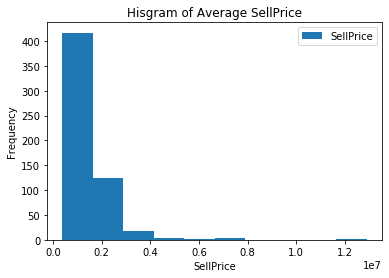

In [433]:
df_hpsd[['SellPrice']].plot(kind='hist')
plt.title('Hisgram of Average SellPrice')
plt.xlabel('SellPrice')
plt.show()

-----

**1.2 Got OC list**

In [434]:
from bs4 import BeautifulSoup
import requests
import urllib.request
import pandas as pd
# get table from url
source = urllib.request.urlopen("https://education.nsw.gov.au/public-schools/selective-high-schools-and-opportunity-classes/year-5/what-are-opportunity-classes/list-of-opportunity-classes").read()
soup = BeautifulSoup(source,'lxml')
table = soup.find('table', attrs={'id':"table45380"})


table_rows = table.find_all('tr')

#extract rows from table and append them into a dataframe
l=[]
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td] 
    l.append(row)
df_oc=pd.DataFrame(l[1:], columns=["Code", "SL"])
df_oc.head()

,Code,SL
0,ACP,"Armidale City Faulkner St, Armidale"
1,ALX,"Alexandria Park Park Rd, Alexandria"
2,ALS,"Alstonville Main St, Alstonville"
3,ART,"Artarmon McMillan Rd, Artarmon"
4,AUR,"Aurora Rural and remote, virtual opportunity c..."


In [435]:
df_oc[['School','suburb']] = df_oc['SL'].str.rsplit(',',n=1, expand=True)
df_oc['suburb']=df_oc['suburb'].str.strip()
df_oc=df_oc.groupby(['suburb'])[['Code']].count().reset_index()
df_oc.head()

,suburb,Code
0,Alexandria,1
1,Alstonville,1
2,Armidale,1
3,Artarmon,1
4,Ashfield,1


In [436]:
#This step add the oc school number to suburbs.
df_hpsd=pd.merge(df_hpsd,df_oc.drop_duplicates(),on='suburb',how='left')
df_hpsd.fillna(0,inplace=True)
df_hpsd.rename(columns={'Code':'CountOfOC'},inplace=True)
df_hpsd.head()

,suburb,SellPrice,IncreaseRate,SDSell,SDIR,CountOfOC
0,Abbotsbury,890091.0,-0.233692,-0.497716,-0.729076,0.0
1,Abbotsford,2490000.0,-0.039475,1.074611,0.154194,0.0
2,Agnes Banks,745000.0,-0.073095,-0.640306,0.001297,0.0
3,Airds,410462.0,-0.338333,-0.969077,-1.204970,0.0
4,Alexandria,1541867.0,-0.000998,0.142823,0.329185,1.0


In [437]:
df_hpsd.shape

(568, 6)

In [440]:
df_geo=pd.read_csv('Australian_Post_Codes_Lat_Lon.csv')

In [441]:
df_geo.head()

,postcode,suburb,state,dc,type,lat,lon
0,200,AUSTRALIAN NATIONAL UNIVERSITY,ACT,AUSTRALIAN NATIONAL UNI LPO,Post Office Boxes,-35.277272,149.117136
1,221,BARTON,ACT,NaN,LVR,-35.201372,149.095065
2,800,DARWIN,NT,DARWIN DELIVERY CENTRE,Delivery Area,-12.801028,130.955789
3,801,DARWIN,NT,DARWIN DELIVERY CENTRE,Post Office Boxes,-12.801028,130.955789
4,804,PARAP,NT,PARAP,Post Office Boxes,-12.432181,130.843310


In [442]:
df_geo['type']=df_geo['type'].str.strip()

In [443]:
df_geo=df_geo[(df_geo['type']=='Delivery Area')&(df_geo['state']=='NSW')]

In [444]:
df_geo.head()

,postcode,suburb,state,dc,type,lat,lon
406,2000,DAWES POINT,NSW,WATERLOO DELIVERY FACILITY,Delivery Area,-33.855601,151.208220
407,2000,HAYMARKET,NSW,WATERLOO DELIVERY FACILITY,Delivery Area,-33.880777,151.202796
408,2000,MILLERS POINT,NSW,WATERLOO DELIVERY FACILITY,Delivery Area,-33.858315,151.203519
409,2000,PARLIAMENT HOUSE,NSW,WATERLOO DELIVERY FACILITY,Delivery Area,-33.867229,151.213051
410,2000,SYDNEY,NSW,WATERLOO DELIVERY FACILITY,Delivery Area,-33.867139,151.207114


In [445]:
df_geo=df_geo[['lon','lat','dc','suburb']]
df_geo['suburb']=df_geo['suburb'].apply(lambda x: x.title())
df_geo.drop_duplicates(['lon','lat','suburb'],inplace=True)
df_geo.head()

,lon,lat,dc,suburb
406,151.208220,-33.855601,WATERLOO DELIVERY FACILITY,Dawes Point
407,151.202796,-33.880777,WATERLOO DELIVERY FACILITY,Haymarket
408,151.203519,-33.858315,WATERLOO DELIVERY FACILITY,Millers Point
409,151.213051,-33.867229,WATERLOO DELIVERY FACILITY,Parliament House
410,151.207114,-33.867139,WATERLOO DELIVERY FACILITY,Sydney


Merge geo info to df_hp

In [446]:
sydney_suburb=pd.merge(df_hpsd,df_geo,on='suburb',how='left')
sydney_suburb.head()

,suburb,SellPrice,IncreaseRate,SDSell,SDIR,CountOfOC,lon,lat,dc
0,Abbotsbury,890091.0,-0.233692,-0.497716,-0.729076,0.0,150.867768,-33.877538,LEIGHTONFIELD DF
1,Abbotsford,2490000.0,-0.039475,1.074611,0.154194,0.0,151.129453,-33.852469,LIDCOMBE DELIVERY CENTRE
2,Agnes Banks,745000.0,-0.073095,-0.640306,0.001297,0.0,150.707372,-33.618877,NEPEAN DF
3,Airds,410462.0,-0.338333,-0.969077,-1.204970,0.0,150.829041,-34.084468,MINTO DC
4,Alexandria,1541867.0,-0.000998,0.142823,0.329185,1.0,151.195567,-33.897571,ALEXANDRIA DF


In [447]:
#rename columns
sydney_suburb.rename(columns={'suburb':'Neighborhood','lon':'Longitude','lat':'Latitude','dc':'Borough'},inplace=True)
sydney_suburb=sydney_suburb[sydney_suburb['Latitude']!=0]
sydney_suburb.dropna(inplace=True)
sydney_suburb.head()

,Neighborhood,SellPrice,IncreaseRate,SDSell,SDIR,CountOfOC,Longitude,Latitude,Borough
0,Abbotsbury,890091.0,-0.233692,-0.497716,-0.729076,0.0,150.867768,-33.877538,LEIGHTONFIELD DF
1,Abbotsford,2490000.0,-0.039475,1.074611,0.154194,0.0,151.129453,-33.852469,LIDCOMBE DELIVERY CENTRE
2,Agnes Banks,745000.0,-0.073095,-0.640306,0.001297,0.0,150.707372,-33.618877,NEPEAN DF
3,Airds,410462.0,-0.338333,-0.969077,-1.204970,0.0,150.829041,-34.084468,MINTO DC
4,Alexandria,1541867.0,-0.000998,0.142823,0.329185,1.0,151.195567,-33.897571,ALEXANDRIA DF


In [448]:
sydney_suburb[sydney_suburb['SellPrice']==sydney_suburb['SellPrice'].min()]

,Neighborhood,SellPrice,IncreaseRate,SDSell,SDIR,CountOfOC,Longitude,Latitude,Borough
557,Willmot,392188.0,-0.21036,-0.987036,-0.622968,0.0,150.791569,-33.727621,NEPEAN DF


In [449]:
# df_geo[df_geo['suburb']=='Epping']

------

**1.4 Finish Cleaning and Generate DF that would be used next**

In [450]:
neighborhoods= sydney_suburb[['Neighborhood','Longitude','Latitude','Borough']]#information for foursquare API

In [451]:
neighborhoods.head()

,Neighborhood,Longitude,Latitude,Borough
0,Abbotsbury,150.867768,-33.877538,LEIGHTONFIELD DF
1,Abbotsford,151.129453,-33.852469,LIDCOMBE DELIVERY CENTRE
2,Agnes Banks,150.707372,-33.618877,NEPEAN DF
3,Airds,150.829041,-34.084468,MINTO DC
4,Alexandria,151.195567,-33.897571,ALEXANDRIA DF


Have a look how many boroughs and neighborhoods we get

In [452]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 38 boroughs and 562 neighborhoods.


**1.5 Use geopy library to get the latitude and longitude values of Sydney City.**

In [453]:
address = 'Sydney NSW,Australia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney City are -33.8548157, 151.2164539.


-----

## 2. Get venues data

#### 2.1 Define Foursquare Credentials and Version

In [108]:
# @hidden
CLIENT_ID = 'BEFIAR32O2VZAZOCBR2IEWDAHELFY0FHSU2DQW0XZ1TK0QM0' # your Foursquare ID
CLIENT_SECRET = 'NDFJJJN3FNGEKGJYE2QFF4VTID2SN0Z5XBDCVO5RHSJS1ZJ4' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 30
# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

Function that extracts the category of the venue

In [109]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Function that get venue data according to latitudes and longitudes

In [110]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except Exception as e:
            print(e)        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called *sydney_venues*.

In [111]:
# type your answer here

sydeny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'])



Abbotsbury
Abbotsford
Agnes Banks
Airds
Alexandria
Alfords Point
Allambie Heights
Allawah
Ambarvale
Annandale
Annangrove
Appin
Arcadia
Arncliffe
Artarmon
Ashbury
Ashcroft
Ashfield
Asquith
Auburn
Austral
Avalon Beach
Badgerys Creek
Balgowlah
Balgowlah Heights
Balmain
Balmain East
Balmoral
Balmoral
Bangor
Banksia
Banksmeadow
Bankstown
Bar Point
Barden Ridge
Bardwell Park
Bardwell Valley
Bargo
Bass Hill
Baulkham Hills
Bayview
Beacon Hill
Beaconsfield
Beaumont Hills
Beecroft
Belfield
Belimbla Park
Bella Vista
Bellevue Hill
Belmore
Belrose
Berala
Berkshire Park
Berowra
Berowra Heights
Berowra Waters
Berrilee
Beverley Park
Beverly Hills
Bexley
Bexley North
Bidwill
Birchgrove
Birrong
Blackett
Blacktown
Blair Athol
Blairmount
Blakehurst
Bligh Park
Bondi
Bondi Beach
Bondi Junction
Bonnet Bay
Bonnyrigg
Bonnyrigg Heights
Bossley Park
Botany
Bow Bowing
Bowen Mountain
Box Hill
Bradbury
Breakfast Point
Brighton-Le-Sands
Bringelly
Bronte
Brooklyn
Brookvale
Brownlow Hill
Bundeena
Burraneer
Burwood
Bur

In [454]:
sydeny_venues.head()

,Neighborhood,Venue Category
0,Abbotsbury,Convenience Store
1,Abbotsbury,Athletics & Sports
2,Abbotsbury,Park
3,Abbotsbury,Supermarket
4,Abbotsbury,Shopping Mall


Use the Venue Category to see the venue dense

In [455]:
print(sydeny_venues.shape)
sydeny_venues=sydeny_venues[['Neighborhood','Venue Category']]
sydeny_venues.head()

(9186, 2)


,Neighborhood,Venue Category
0,Abbotsbury,Convenience Store
1,Abbotsbury,Athletics & Sports
2,Abbotsbury,Park
3,Abbotsbury,Supermarket
4,Abbotsbury,Shopping Mall


In [456]:
print('There are {} uniques categories.'.format(len(sydeny_venues['Venue Category'].unique())))

There are 356 uniques categories.


In [457]:
CountOfVenue=sydeny_venues.groupby('Neighborhood').count().reset_index()
CountOfVenue.head()

,Neighborhood,Venue Category
0,Abbotsbury,12
1,Abbotsford,20
2,Agnes Banks,3
3,Airds,6
4,Alexandria,30


## 3. Analyze Each Neighborhood

In [516]:
# one hot encoding
sydney_onehot = pd.get_dummies(sydeny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sydney_onehot['Neighborhood'] = sydeny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

# sydney_onehot.head()

In [517]:
sydney_grouped = sydney_onehot.groupby('Neighborhood').mean().reset_index()

In [518]:
sydney_grouped2=pd.merge(sydney_grouped,sydney_suburb[['Neighborhood','SDSell','SDIR']],on='Neighborhood',how='left')

In [519]:
sydney_grouped2.shape

(623, 358)

In [520]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [521]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sydney_grouped['Neighborhood']

for ind in np.arange(sydney_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sydney_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted=pd.merge(sydney_grouped2[['Neighborhood','SDSell','SDIR']],neighborhoods_venues_sorted,on='Neighborhood',how='left')
neighborhoods_venues_sorted.head()

,Neighborhood,SDSell,SDIR,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbotsbury,-0.497716,-0.729076,Convenience Store,Other Great Outdoors,Park,Supermarket,Shopping Mall,Athletics & Sports,Italian Restaurant,Garden Center,Deli / Bodega,Football Stadium
1,Abbotsford,1.074611,0.154194,Café,Pizza Place,Italian Restaurant,Thai Restaurant,Pier,Gym,Park,Grocery Store,Liquor Store,Wine Shop
2,Agnes Banks,-0.640306,0.001297,Home Service,Campground,Rental Car Location,Women's Store,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market
3,Airds,-0.969077,-1.204970,Pub,Fish & Chips Shop,Gas Station,Gym,Shopping Mall,Bakery,Women's Store,Food,Filipino Restaurant,Fish Market
4,Alexandria,0.142823,0.329185,Café,Bar,Pub,Vietnamese Restaurant,Bakery,Coffee Shop,Performing Arts Venue,Bistro,Gourmet Shop,Farmers Market


In [522]:
neighborhoods_venues_sorted.dropna(inplace=True)

## 4.Clustering

In [524]:
sydney_grouped2.dropna(inplace=True)

In [525]:
# set number of clusters
kclusters = 6

sydney_grouped_clustering = sydney_grouped2.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sydney_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 1, 2, 1, 1, 4, 2, 1, 4], dtype=int32)

In [526]:
len(kmeans.labels_)

545

In [527]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [528]:
neighborhoods_venues_sorted.drop_duplicates(inplace=True)

In [529]:
sydney_merged=pd.merge(neighborhoods_venues_sorted,sydney_suburb[['Neighborhood','Longitude','Latitude','SellPrice','IncreaseRate']],on='Neighborhood',how='left')

In [530]:
sydney_merged.head(1)

,Cluster Labels,Neighborhood,SDSell,SDIR,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Longitude,Latitude,SellPrice,IncreaseRate
0,2,Abbotsbury,-0.497716,-0.729076,Convenience Store,Other Great Outdoors,Park,Supermarket,Shopping Mall,Athletics & Sports,Italian Restaurant,Garden Center,Deli / Bodega,Football Stadium,150.867768,-33.877538,890091.0,-0.233692


In [531]:
fixed_columns2=list(sydney_merged.columns[0:2])+list(sydney_merged.columns[-2:])+ list(sydney_merged.columns[2:-2])
sydney_merged = sydney_merged[fixed_columns2]

In [532]:
sydney_merged=pd.merge(sydney_merged,CountOfVenue,on='Neighborhood',how='left')

In [533]:
sydney_merged.head()

,Cluster Labels,Neighborhood,SellPrice,IncreaseRate,SDSell,SDIR,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Longitude,Latitude,Venue Category
0,2,Abbotsbury,890091.0,-0.233692,-0.497716,-0.729076,Convenience Store,Other Great Outdoors,Park,Supermarket,Shopping Mall,Athletics & Sports,Italian Restaurant,Garden Center,Deli / Bodega,Football Stadium,150.867768,-33.877538,12
1,4,Abbotsford,2490000.0,-0.039475,1.074611,0.154194,Café,Pizza Place,Italian Restaurant,Thai Restaurant,Pier,Gym,Park,Grocery Store,Liquor Store,Wine Shop,151.129453,-33.852469,20
2,1,Agnes Banks,745000.0,-0.073095,-0.640306,0.001297,Home Service,Campground,Rental Car Location,Women's Store,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,150.707372,-33.618877,3
3,2,Airds,410462.0,-0.338333,-0.969077,-1.204970,Pub,Fish & Chips Shop,Gas Station,Gym,Shopping Mall,Bakery,Women's Store,Food,Filipino Restaurant,Fish Market,150.829041,-34.084468,6
4,1,Alexandria,1541867.0,-0.000998,0.142823,0.329185,Café,Bar,Pub,Vietnamese Restaurant,Bakery,Coffee Shop,Performing Arts Venue,Bistro,Gourmet Shop,Farmers Market,151.195567,-33.897571,30


In [552]:
sydney_merged[sydney_merged['Neighborhood']=='Beecroft']

,Cluster Labels,Neighborhood,SellPrice,IncreaseRate,SDSell,SDIR,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Longitude,Latitude,Venue Category
40,4,Beecroft,1647825.0,-0.098756,0.246955,-0.115408,Café,Park,Italian Restaurant,Liquor Store,Supermarket,Shopping Mall,Chinese Restaurant,Donut Shop,Food Court,Fishing Spot,151.064533,-33.749498,10


In [535]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [536]:
df=pd.merge(sydney_merged[['SellPrice','IncreaseRate','Cluster Labels','Neighborhood','Venue Category']],sydney_suburb[['Neighborhood','CountOfOC']],on='Neighborhood',how='left')

In [537]:
df.head()

,SellPrice,IncreaseRate,Cluster Labels,Neighborhood,Venue Category,CountOfOC
0,890091.0,-0.233692,2,Abbotsbury,12,0.0
1,2490000.0,-0.039475,4,Abbotsford,20,0.0
2,745000.0,-0.073095,1,Agnes Banks,3,0.0
3,410462.0,-0.338333,2,Airds,6,0.0
4,1541867.0,-0.000998,1,Alexandria,30,1.0


In [538]:
summarize=df.groupby('Cluster Labels').describe().round(2)
summarize

SellPrice                                                 \
                   count        mean         std        min         25%   
Cluster Labels                                                            
0                   18.0  1365650.72   534433.05   825000.0   925000.00   
1                  325.0   935110.92   305203.77   392188.0   695841.00   
2                   93.0  1265623.42   427439.20   410462.0   933833.00   
3                    2.0  8825000.00  5762920.27  4750000.0  6787500.00   
4                  124.0  2297453.27   524768.79  1567143.0  1868645.75   
5                    7.0  5768744.00  1120893.94  4573333.0  4877937.50   

                                                   IncreaseRate              \
                      50%          75%         max        count  mean   std   
Cluster Labels                                                                
0               1176166.5   1662500.00   2757500.0         18.0  0.37  0.17   
1                860000.0   1146636.00   1622634.0        325.0 -0.08  0.07   
2               1235036.0   1567833.00   2800000.0         93.0 -0.28  0.09   
3               8825000.0  10862500.00  12900000.0          2.0  1.81  0.66   
4               2200819.5   2632951.25   3904375.0        124.0 -0.06  0.12   
5               5482000.0   6505000.00   7560000.0          7.0  0.33  0.46   

                                             Venue Category                \
                 min   25%   50%   75%   max          count   mean    std   
Cluster Labels                                                              
0               0.18  0.25  0.34  0.40  0.87           18.0   7.22   8.25   
1              -0.21 -0.12 -0.08 -0.05  0.15          325.0  13.19   9.79   
2              -0.60 -0.32 -0.26 -0.19 -0.16           93.0  13.69  10.18   
3               1.35  1.58  1.81  2.04  2.28            2.0  26.50   4.95   
4              -0.36 -0.13 -0.06  0.02  0.20          124.0  21.92  11.86   
5              -0.18  0.01  0.33  0.52  1.14            7.0  23.14  10.59   

                                               CountOfOC                   \
                 min    25%   50%    75%   max     count  mean   std  min   
Cluster Labels                                                              
0                1.0   3.00   4.0   6.50  30.0      18.0  0.00  0.00  0.0   
1                1.0   5.00  10.0  21.00  30.0     325.0  0.10  0.30  0.0   
2                2.0   5.00  10.0  19.00  33.0      93.0  0.08  0.27  0.0   
3               23.0  24.75  26.5  28.25  30.0       2.0  0.00  0.00  0.0   
4                1.0  12.75  23.0  30.00  59.0     124.0  0.06  0.25  0.0   
5                5.0  18.50  30.0  30.00  30.0       7.0  0.00  0.00  0.0   

                                    
                25%  50%  75%  max  
Cluster Labels                      
0               0.0  0.0  0.0  0.0  
1               0.0  0.0  0.0  1.0  
2               0.0  0.0  0.0  1.0  
3               0.0  0.0  0.0  0.0  
4               0.0  0.0  0.0  1.0  
5               0.0  0.0  0.0  0.0

In [561]:
# Result=summarize.iloc[:,[0,1,9,17,25]]
Result=summarize.iloc[:,[0,5,13,21,29]]
Result

SellPrice            IncreaseRate Venue Category CountOfOC
                   count        50%          50%            50%       50%
Cluster Labels                                                           
0                   18.0  1176166.5         0.34            4.0       0.0
1                  325.0   860000.0        -0.08           10.0       0.0
2                   93.0  1235036.0        -0.26           10.0       0.0
3                    2.0  8825000.0         1.81           26.5       0.0
4                  124.0  2200819.5        -0.06           23.0       0.0
5                    7.0  5482000.0         0.33           30.0       0.0

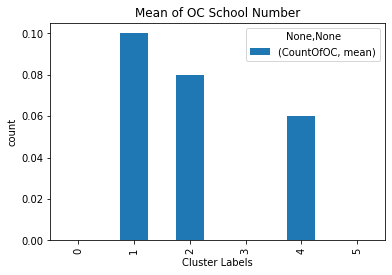

In [540]:
df_count=Result.iloc[:,[4]]
df_count.plot(kind='bar', figsize=(6, 4))

plt.xlabel('Cluster Labels') # add to x-label to the plot
plt.ylabel('count') # add y-label to the plot
plt.title('Mean of OC School Number') # add title to the plot

plt.show()

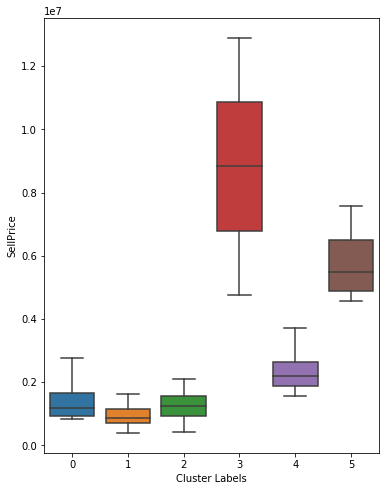

In [546]:
plt.figure(figsize=(6,8))
ax1 = sns.boxplot(x="Cluster Labels", y="SellPrice", data=df,showfliers=False)


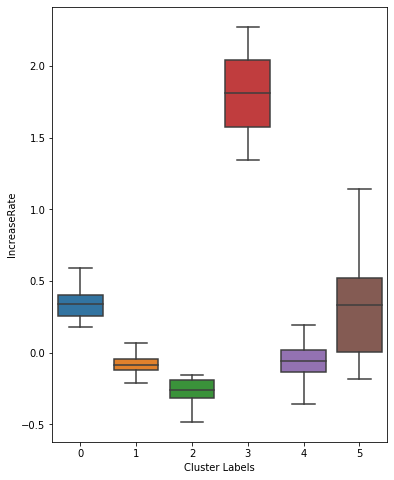

In [548]:
plt.figure(figsize=(6,8))
ax2 = sns.boxplot(x="Cluster Labels", y="IncreaseRate", data=df,showfliers=False)


In [543]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
color=['blue','orange','green','red','purple','brown']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['Latitude'], sydney_merged['Longitude'], sydney_merged['Neighborhood'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color[cluster],
        fill=True,
        fill_color=color[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters